# Lab 3: Weakest Link Classification
## 4DV652 - Data Intensive Systems

**Project:** Automated Movement Assessment (AIMO)  
**Task:** Classify which joint/body region is the weakest link during a movement

### Data Structure (UPDATED)
The data is now provided as:
- **Single CSV file:** train_dataset.csv
- **Pre-merged:** Movement features + weak link scores combined
- **Pre-split:** Training data ready to use

### Weak Link Classes (14 categories)
ForwardHead, LeftArmFallForward, RightArmFallForward, LeftShoulderElevation, RightShoulderElevation, ExcessiveForwardLean, LeftAsymmetricalWeightShift, RightAsymmetricalWeightShift, LeftKneeMovesInward, RightKneeMovesInward, LeftKneeMovesOutward, RightKneeMovesOutward, LeftHeelRises, RightHeelRises

## Step 0: Setup & Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

print("✓ All imports successful")
print(f"✓ Pandas version: {pd.__version__}")

✓ All imports successful
✓ Pandas version: 2.3.3


## Step 1: Data Loading & Exploration

**What we're doing:**
- Loading the pre-merged CSV file
- Contains both movement features (38) and weak link scores (14)
- Creating classification target

**What to expect:**
- CSV loads successfully
- ~1600-1700 rows
- 38 movement features
- 14 weak link score columns

In [14]:
TRAIN_DATA_PATH = "/Users/reemothman/Downloads/Data-intensive-systems/A3/A3_Data/output.csv"

print("="*80)
print("STEP 1: DATA LOADING & EXPLORATION")
print("="*80)

try:
    df = pd.read_csv(TRAIN_DATA_PATH)
    print(f"\n✓ Loaded training dataset: {df.shape}")
    print(f"  Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nColumn names:")
    print(df.columns.tolist())
except FileNotFoundError:
    print(f"Error: File not found at {TRAIN_DATA_PATH}")
    print("Please update TRAIN_DATA_PATH to your actual file location")
    raise

STEP 1: DATA LOADING & EXPLORATION

✓ Loaded training dataset: (1675, 59)
  Rows: 1675, Columns: 59

First few rows:
                                            ID        Date     SCORE  \
0  b7ff5265-b23a-4142-863e-c35b2b45494e.Kinect  2018-08-27  0.496481   
1  f0defe1c-972c-4862-9746-df716077832e.Kinect  2018-06-06  0.080412   
2  cc7adf06-dcda-4187-ab80-16f073e76c8b.Kinect  2018-05-31  0.879840   
3  2dd37697-85a8-4daa-aa3d-7d9225faeebb.Kinect  2018-07-20  0.554598   
4  1cf45dd6-821f-444d-a102-5e94dca748a8.Kinect  2018-07-18  0.793089   

   ForwardHead  LeftArmFallForward  RightArmFallForward  \
0         0.37                0.77                 1.06   
1         0.28                1.06                 1.40   
2         0.00                0.14                 1.08   
3         0.00                0.02                 0.16   
4         0.00                0.06                 0.01   

   LeftShoulderElevation  RightShoulderElevation  ExcessiveForwardLean  \
0                   0

In [15]:
WEAK_LINK_TYPES = [
    'ForwardHead',
    'LeftArmFallForward', 'RightArmFallForward',
    'LeftShoulderElevation', 'RightShoulderElevation',
    'ExcessiveForwardLean',
    'LeftAsymmetricalWeightShift', 'RightAsymmetricalWeightShift',
    'LeftKneeMovesInward', 'RightKneeMovesInward',
    'LeftKneeMovesOutward', 'RightKneeMovesOutward',
    'LeftHeelRises', 'RightHeelRises'
]

print(f"Defined {len(WEAK_LINK_TYPES)} weak link categories")

# Identify columns
weak_link_cols = [col for col in df.columns if any(wl in col for wl in WEAK_LINK_TYPES)]
movement_cols = [col for col in df.columns if 'Angle' in col or 'NASM' in col or 'Time' in col]

print(f"✓ Found {len(movement_cols)} movement feature columns")
print(f"✓ Found {len(weak_link_cols)} weak link score columns")

Defined 14 weak link categories
✓ Found 40 movement feature columns
✓ Found 14 weak link score columns


In [16]:
print("\nCreating target variable...")
df['Weakest_Link'] = df[weak_link_cols].idxmax(axis=1)
df['Weakest_Link_Score'] = df[weak_link_cols].max(axis=1)

print(f"\n✓ Added 'Weakest_Link' target column")
print(f"\nClass distribution:")
class_dist = df['Weakest_Link'].value_counts()
print(class_dist)

print(f"\nClass imbalance ratio: {class_dist.max() / class_dist.min():.2f}:1")


Creating target variable...

✓ Added 'Weakest_Link' target column

Class distribution:
Weakest_Link
LeftArmFallForward              492
RightArmFallForward             384
RightKneeMovesOutward           225
RightShoulderElevation          203
ForwardHead                      92
ExcessiveForwardLean             81
LeftAsymmetricalWeightShift      62
LeftShoulderElevation            45
RightKneeMovesInward             37
LeftKneeMovesOutward             33
RightAsymmetricalWeightShift     15
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: count, dtype: int64

Class imbalance ratio: 492.00:1


In [17]:
print("\nPreparing dataset for modeling...")
X = df[movement_cols].copy()
y = df['Weakest_Link'].copy()

print(f"✓ Feature matrix X shape: {X.shape}")
print(f"✓ Target vector y shape: {y.shape}")
print(f"\nMissing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    X = X.fillna(X.mean())
    y = y.dropna()
    X = X.loc[y.index]
    print(f"After handling: X={X.shape}, y={y.shape}")
else:
    print("✓ No missing values - data is clean")


Preparing dataset for modeling...
✓ Feature matrix X shape: (1675, 40)
✓ Target vector y shape: (1675,)

Missing values in X: 0
Missing values in y: 0
✓ No missing values - data is clean


## Step 2: Exploratory Data Analysis

In [18]:
print("\n" + "="*80)
print("STEP 2: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

le_temp = LabelEncoder()
y_encoded_temp = le_temp.fit_transform(y)
mi_scores = mutual_info_classif(X, y_encoded_temp, random_state=42)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mi_scores
}).sort_values('Mutual_Information', ascending=False)

print(f"\nTop 10 Most Informative Features:")
print(feature_importance.head(10).to_string(index=False))


STEP 2: FEATURE IMPORTANCE ANALYSIS

Top 10 Most Informative Features:
              Feature  Mutual_Information
 No_12_NASM_Deviation            0.324848
 No_5_Angle_Deviation            0.324425
  No_1_NASM_Deviation            0.317476
  No_7_NASM_Deviation            0.308335
 No_7_Angle_Deviation            0.298118
  No_2_NASM_Deviation            0.293056
  No_5_NASM_Deviation            0.287701
 No_10_NASM_Deviation            0.282665
No_13_Angle_Deviation            0.277329
No_12_Angle_Deviation            0.265828


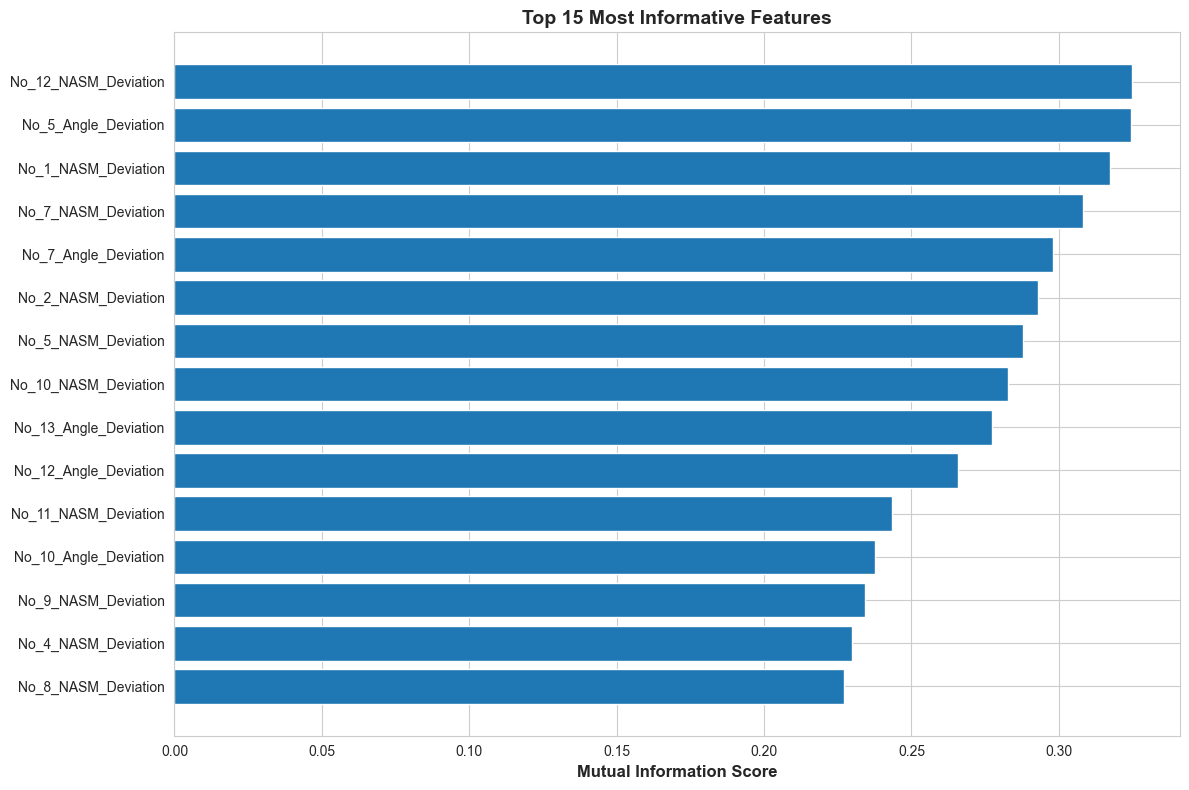

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['Mutual_Information'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Mutual Information Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Informative Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Step 3: Data Preprocessing - Train-Validation Split & Scaling

In [22]:
print("\n" + "="*80)
print("STEP 3: TRAIN-VALIDATION SPLIT & SCALING")
print("="*80)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Show class distribution
class_counts = pd.Series(y).value_counts()
print(class_counts)

# ---------------------------
# FIX: remove rare classes
# ---------------------------
min_samples = 2   # stratified split requires at least 2

valid_classes = class_counts[class_counts >= min_samples].index

mask = pd.Series(y).isin(valid_classes)

X_filtered = X[mask]
y_filtered = y[mask]

print("\nRemoved classes with < 2 samples:")
print(class_counts[class_counts < min_samples])

print(f"\nRemaining samples: {len(y_filtered)}")

# ---------------------------
# Train / validation split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered,
    y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# ---------------------------
# Feature scaling
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\n✓ Feature scaling completed")
print(f"  Mean: {X_train_scaled.mean():.6f}")
print(f"  Std Dev: {X_train_scaled.std():.6f}")

# ---------------------------
# Label encoding
# ---------------------------
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print(f"\n✓ Target variable encoded")
print(f"  Classes: {list(label_encoder.classes_)}")



STEP 3: TRAIN-VALIDATION SPLIT & SCALING
Weakest_Link
LeftArmFallForward              492
RightArmFallForward             384
RightKneeMovesOutward           225
RightShoulderElevation          203
ForwardHead                      92
ExcessiveForwardLean             81
LeftAsymmetricalWeightShift      62
LeftShoulderElevation            45
RightKneeMovesInward             37
LeftKneeMovesOutward             33
RightAsymmetricalWeightShift     15
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: count, dtype: int64

Removed classes with < 2 samples:
Weakest_Link
RightHeelRises    1
Name: count, dtype: int64

Remaining samples: 1674

Training set: 1339 samples
Validation set: 335 samples
Features: 40

✓ Feature scaling completed
  Mean: 0.000000
  Std Dev: 1.000000

✓ Target variable encoded
  Classes: ['ExcessiveForwardLean', 'ForwardHead', 'LeftArmFallForward', 'LeftAsymmetricalWeightShift', 'LeftHeelRises', 'LeftKneeMove

## Step 4: Train Classification Models

In [23]:
print("\n" + "="*80)
print("STEP 4: TRAINING CLASSIFICATION MODELS")
print("="*80)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
    'Random Forest (10 trees)': RandomForestClassifier(n_estimators=10, random_state=42),
    'Random Forest (50 trees)': RandomForestClassifier(n_estimators=50, random_state=42)
}

trained_models = {}
train_predictions = {}
val_predictions = {}

print("\nTraining models...\n")

for name, model in models.items():
    print(f"Training {name}...", end=' ')
    model.fit(X_train_scaled, y_train_encoded)
    trained_models[name] = model
    
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    train_predictions[name] = y_train_pred
    val_predictions[name] = y_val_pred
    
    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    val_acc = accuracy_score(y_val_encoded, y_val_pred)
    
    print(f"✓ (Train: {train_acc:.4f}, Val: {val_acc:.4f})")

print(f"\n✓ All {len(models)} models trained")


STEP 4: TRAINING CLASSIFICATION MODELS

Training models...

Training Logistic Regression... ✓ (Train: 0.6721, Val: 0.6209)
Training KNN (k=5)... ✓ (Train: 0.6990, Val: 0.5791)
Training KNN (k=10)... ✓ (Train: 0.6497, Val: 0.5522)
Training Linear Discriminant Analysis... ✓ (Train: 0.6258, Val: 0.6060)
Training Quadratic Discriminant Analysis... ✓ (Train: 0.5101, Val: 0.4000)
Training Random Forest (10 trees)... ✓ (Train: 0.9873, Val: 0.5552)
Training Random Forest (50 trees)... ✓ (Train: 1.0000, Val: 0.5881)

✓ All 7 models trained


## Step 5: Model Evaluation

In [24]:
print("\n" + "="*80)
print("STEP 5: MODEL EVALUATION")
print("="*80)

results = []

for model_name in models.keys():
    y_pred = val_predictions[model_name]
    y_train_pred = train_predictions[model_name]
    
    val_acc = accuracy_score(y_val_encoded, y_pred)
    precision = precision_score(y_val_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val_encoded, y_pred, average='weighted', zero_division=0)
    
    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    gap = train_acc - val_acc
    
    results.append({
        'Model': model_name,
        'Train_Accuracy': train_acc,
        'Val_Accuracy': val_acc,
        'Precision': precision,
        'Recall': recall,
        'F1_Weighted': f1,
        'Overfitting_Gap': gap
    })

results_df = pd.DataFrame(results).sort_values('Val_Accuracy', ascending=False)

print("\nMODEL COMPARISON:")
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"    Validation Accuracy: {results_df.iloc[0]['Val_Accuracy']:.4f}")
print(f"    F1-Score: {results_df.iloc[0]['F1_Weighted']:.4f}")


STEP 5: MODEL EVALUATION

MODEL COMPARISON:
                          Model  Train_Accuracy  Val_Accuracy  Precision   Recall  F1_Weighted  Overfitting_Gap
            Logistic Regression        0.672143      0.620896   0.605825 0.620896     0.609461         0.051248
   Linear Discriminant Analysis        0.625840      0.605970   0.601050 0.605970     0.599636         0.019870
       Random Forest (50 trees)        1.000000      0.588060   0.580766 0.588060     0.567850         0.411940
                      KNN (k=5)        0.699029      0.579104   0.578986 0.579104     0.569153         0.119925
       Random Forest (10 trees)        0.987304      0.555224   0.527321 0.555224     0.532962         0.432080
                     KNN (k=10)        0.649739      0.552239   0.547181 0.552239     0.540325         0.097500
Quadratic Discriminant Analysis        0.510082      0.400000   0.404383 0.400000     0.386700         0.110082

🏆 BEST MODEL: Logistic Regression
    Validation Accuracy:

In [26]:
from sklearn.metrics import classification_report
import numpy as np

print("\nCLASSIFICATION REPORT:")

y_pred_best = val_predictions[best_model_name]

labels_present = np.unique(np.concatenate([y_val_encoded, y_pred_best]))

target_names_present = label_encoder.inverse_transform(labels_present)

print(classification_report(
    y_val_encoded,
    y_pred_best,
    labels=labels_present,
    target_names=target_names_present,
    digits=4
))



CLASSIFICATION REPORT:
                              precision    recall  f1-score   support

        ExcessiveForwardLean     0.4737    0.5625    0.5143        16
                 ForwardHead     0.6190    0.7222    0.6667        18
          LeftArmFallForward     0.6226    0.6667    0.6439        99
 LeftAsymmetricalWeightShift     0.6000    0.5000    0.5455        12
         LeftKneeMovesInward     0.0000    0.0000    0.0000         1
        LeftKneeMovesOutward     0.6667    0.2857    0.4000         7
       LeftShoulderElevation     0.0000    0.0000    0.0000         9
         RightArmFallForward     0.5556    0.5195    0.5369        77
RightAsymmetricalWeightShift     0.4000    0.6667    0.5000         3
        RightKneeMovesInward     0.3333    0.1429    0.2000         7
       RightKneeMovesOutward     0.9362    0.9778    0.9565        45
      RightShoulderElevation     0.5435    0.6098    0.5747        41

                    accuracy                         0.6209     

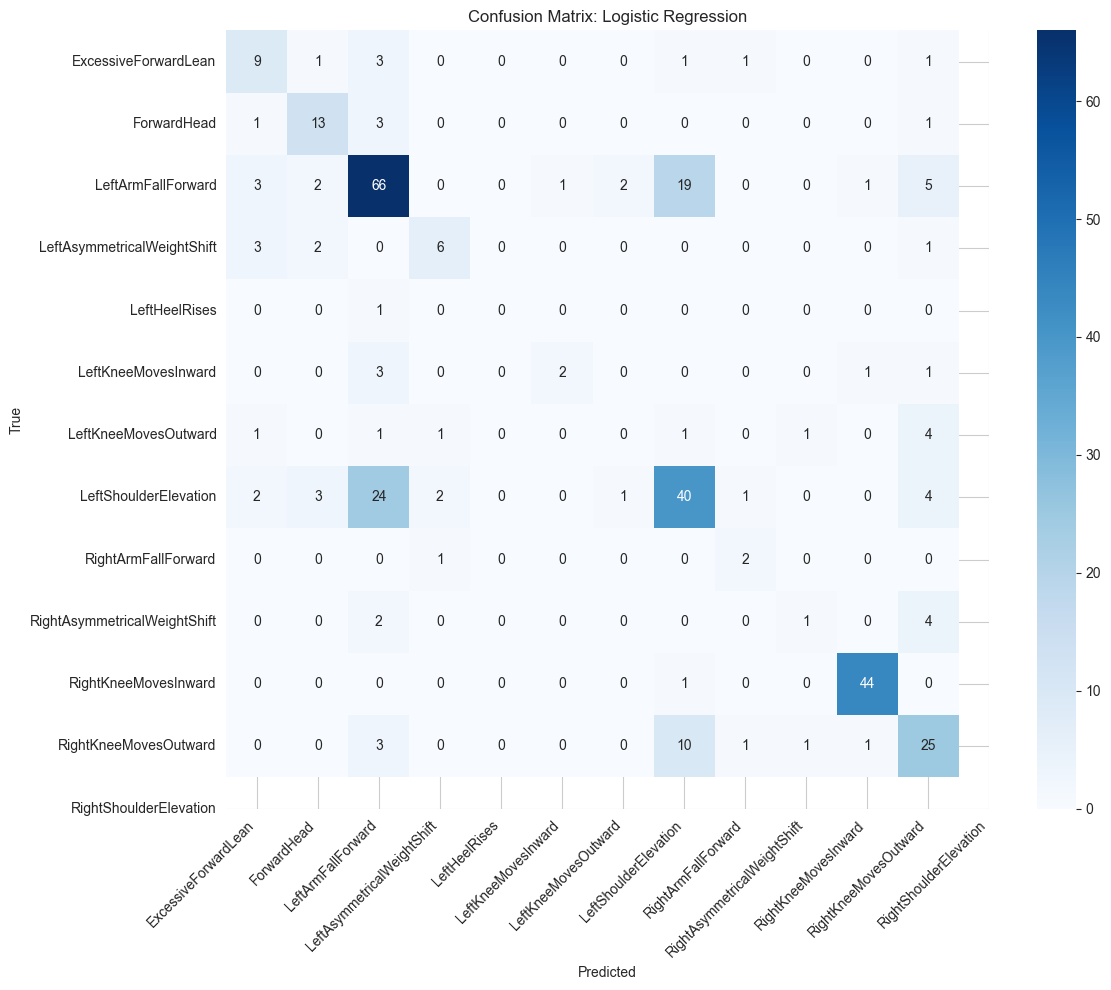

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_val_encoded, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion Matrix: {best_model_name}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Step 6: Cross-Validation

In [28]:
print("\n" + "="*80)
print("STEP 6: CROSS-VALIDATION")
print("="*80)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nPerforming 5-fold cross-validation...\n")

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=skf, scoring='accuracy')
    print(f"{model_name}:")
    print(f"  Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Folds: {[f'{x:.4f}' for x in cv_scores]}")
    print()


STEP 6: CROSS-VALIDATION

Performing 5-fold cross-validation...

Logistic Regression:
  Mean: 0.5631 ± 0.0204
  Folds: ['0.5709', '0.5933', '0.5522', '0.5672', '0.5318']

KNN (k=5):
  Mean: 0.5347 ± 0.0154
  Folds: ['0.5299', '0.5336', '0.5299', '0.5634', '0.5169']

KNN (k=10):
  Mean: 0.5362 ± 0.0194
  Folds: ['0.5410', '0.5448', '0.5448', '0.5522', '0.4981']

Linear Discriminant Analysis:
  Mean: 0.5541 ± 0.0148
  Folds: ['0.5634', '0.5485', '0.5784', '0.5410', '0.5393']

Quadratic Discriminant Analysis:
  Mean: nan ± nan
  Folds: ['nan', 'nan', 'nan', 'nan', '0.4270']

Random Forest (10 trees):
  Mean: 0.5422 ± 0.0324
  Folds: ['0.5522', '0.5709', '0.5149', '0.5784', '0.4944']

Random Forest (50 trees):
  Mean: 0.5945 ± 0.0175
  Folds: ['0.5858', '0.6119', '0.5970', '0.6119', '0.5655']



## Step 7: Feature Selection

In [29]:
print("\n" + "="*80)
print("STEP 7: FEATURE SELECTION (RFE)")
print("="*80)

best_model_instance = trained_models[best_model_name]
n_features_to_try = [10, 15, 20, 25, 30, X_train.shape[1]]

rfe_results = []

print(f"\nTesting different feature counts...\n")

for n_features in n_features_to_try:
    if n_features > X_train.shape[1]:
        n_features = X_train.shape[1]
    
    rfe = RFE(best_model_instance, n_features_to_select=n_features)
    rfe.fit(X_train_scaled, y_train_encoded)
    
    X_train_rfe = rfe.transform(X_train_scaled)
    X_val_rfe = rfe.transform(X_val_scaled)
    
    model_rfe = type(best_model_instance)(**best_model_instance.get_params())
    model_rfe.fit(X_train_rfe, y_train_encoded)
    
    y_val_pred_rfe = model_rfe.predict(X_val_rfe)
    val_acc_rfe = accuracy_score(y_val_encoded, y_val_pred_rfe)
    
    reduction = (1 - n_features / X_train.shape[1]) * 100
    print(f"Features: {n_features:2d} | Reduction: {reduction:5.1f}% | Val Acc: {val_acc_rfe:.4f}")
    
    rfe_results.append({'Features': n_features, 'Reduction_%': reduction, 'Val_Accuracy': val_acc_rfe})


STEP 7: FEATURE SELECTION (RFE)

Testing different feature counts...

Features: 10 | Reduction:  75.0% | Val Acc: 0.5672
Features: 15 | Reduction:  62.5% | Val Acc: 0.5910
Features: 20 | Reduction:  50.0% | Val Acc: 0.5910
Features: 25 | Reduction:  37.5% | Val Acc: 0.6000
Features: 30 | Reduction:  25.0% | Val Acc: 0.6149
Features: 40 | Reduction:   0.0% | Val Acc: 0.6209


## Step 8: Final Summary

In [31]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\n DATASET:")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")
print(f"  Classes: {len(label_encoder.classes_)}")

print(f"\n CHAMPION MODEL:")
print(f"  Name: {best_model_name}")
print(f"  Validation Accuracy: {results_df.iloc[0]['Val_Accuracy']:.4f}")
print(f"  F1-Score: {results_df.iloc[0]['F1_Weighted']:.4f}")
print(f"  Overfitting Gap: {results_df.iloc[0]['Overfitting_Gap']:.4f}")

print(f"\n✓ Lab 3 - ML Phase: COMPLETE")


FINAL SUMMARY

 DATASET:
  Samples: 1675
  Features: 40
  Classes: 13

 CHAMPION MODEL:
  Name: Logistic Regression
  Validation Accuracy: 0.6209
  F1-Score: 0.6095
  Overfitting Gap: 0.0512

✓ Lab 3 - ML Phase: COMPLETE


## Step 9: Save Models

In [32]:
import joblib
import os

output_path = "./models"
os.makedirs(output_path, exist_ok=True)

best_model_instance = trained_models[best_model_name]

joblib.dump(best_model_instance, os.path.join(output_path, 'weakest_link_classifier.pkl'))
joblib.dump(scaler, os.path.join(output_path, 'scaler.pkl'))
joblib.dump(label_encoder, os.path.join(output_path, 'label_encoder.pkl'))

with open(os.path.join(output_path, 'feature_names.txt'), 'w') as f:
    for feat in X.columns:
        f.write(f"{feat}\n")

results_df.to_csv(os.path.join(output_path, 'model_results.csv'), index=False)

print(f"✓ Model saved to {output_path}/weakest_link_classifier.pkl")
print(f"✓ Scaler saved to {output_path}/scaler.pkl")
print(f"✓ Label encoder saved to {output_path}/label_encoder.pkl")
print(f"✓ Feature names saved to {output_path}/feature_names.txt")
print(f"✓ Results saved to {output_path}/model_results.csv")

✓ Model saved to ./models/weakest_link_classifier.pkl
✓ Scaler saved to ./models/scaler.pkl
✓ Label encoder saved to ./models/label_encoder.pkl
✓ Feature names saved to ./models/feature_names.txt
✓ Results saved to ./models/model_results.csv
